In [40]:
import numpy as np
import matplotlib.pyplot as plt
import os, cv2
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.utils import to_categorical, Sequence
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dropout, Flatten, Dense
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras import regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tqdm import tqdm      # a nice pretty percentage bar for tasks.
from random import shuffle

In [63]:
TRAIN_DIR = '../input/train/'
TRAIN_DIR_DOG = '../input/train/dog/' 
TRAIN_DIR_CAT = '../input/train/cat/'

VAL_DIR = '../input/validation/'
VAL_DIR_DOG = '../input/validation/dog/'
VAL_DIR_CAT = '../input/validation/cat/'

ROWS = 64
COLS = 64
CHANNELS = 3
TOTAL_COUNT = 12500
TRAIN_COUNT = int(TOTAL_COUNT*0.8)
VAL_COUNT = int(TOTAL_COUNT*0.2)

data_dict = {}

dog_train_list = [TRAIN_DIR_DOG+name for i,name in \
                  enumerate(os.listdir(TRAIN_DIR_DOG)) if i < TRAIN_COUNT]
cat_train_list = [TRAIN_DIR_CAT+name for i,name in \
                  enumerate(os.listdir(TRAIN_DIR_CAT)) if i < TRAIN_COUNT]

data_dict['train_data'] = dog_train_list + cat_train_list
data_dict['train_labels'] = [1]*TRAIN_COUNT + [0]*TRAIN_COUNT

dog_val_list = [VAL_DIR_DOG+name for i, name in \
                enumerate(os.listdir(VAL_DIR_DOG)) if i < VAL_COUNT]
cat_val_list = [VAL_DIR_CAT+name for i, name in \
                enumerate(os.listdir(VAL_DIR_CAT)) if i < VAL_COUNT]

data_dict['val_data'] = dog_val_list + cat_val_list
data_dict['val_labels']= [1]*VAL_COUNT + [0]*VAL_COUNT
          
print(len(data_dict['train_data']))
print(len(data_dict['val_data']))


20000
5000


In [64]:
def load_image(file_path, size=(ROWS,COLS)):
    img = cv2.imread(file_path, cv2.IMREAD_COLOR)
    b,g,r = cv2.split(img)
    rgb_img = cv2.merge([r,g,b])
    return cv2.resize(rgb_img, (ROWS,COLS))
    

def load_image_list(file_list):
    count = len(file_list)
    data = np.ndarray((count, ROWS, COLS, CHANNELS),\
                      dtype=np.uint8)
    for i, image_name in tqdm(enumerate(file_list)):
        data[i] = load_image(image_name)
    return data / 255.0
    
data_dict['train_data'] = load_image_list(\
                            data_dict['train_data'])
data_dict['val_data'] = load_image_list(\
                            data_dict['val_data'])

20000it [00:56, 353.15it/s]
5000it [00:20, 240.31it/s]


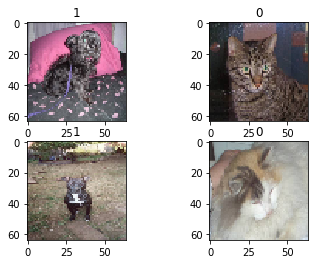

In [65]:
f, axarr = plt.subplots(2,2)
axarr[0,0].set_title(data_dict['train_labels'][0])
axarr[0,0].imshow(data_dict['train_data'][0])

axarr[1,0].set_title(data_dict['train_labels'][TRAIN_COUNT-1])
axarr[1,0].imshow(data_dict['train_data'][TRAIN_COUNT-1])

axarr[0,1].set_title(data_dict['train_labels'][TRAIN_COUNT])
axarr[0,1].imshow(data_dict['train_data'][TRAIN_COUNT])

axarr[1,1].set_title(data_dict['train_labels'][TRAIN_COUNT*2 -1])
axarr[1,1].imshow(data_dict['train_data'][TRAIN_COUNT*2 -1])
plt.show()

In [66]:
model = Sequential()
model.add(Conv2D(filters=4, kernel_size=(4,4),\
                 padding='Same', activation='relu',\
                 input_shape=(ROWS,COLS,CHANNELS)))
model.add(Conv2D(filters=8, kernel_size=(4,4),\
                 padding='Same', activation='relu'))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Conv2D(filters=16, kernel_size=(8,8),\
                 padding='Same', activation='relu'))
model.add(Conv2D(filters=32, kernel_size=(8,8),\
                 padding='Same', activation='relu'))
model.add(MaxPool2D(pool_size=(4,4)))

model.add(Flatten())
model.add(Dense(8**2, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

optimizer = SGD(lr=0.01)
model.compile(optimizer=optimizer,
              loss="binary_crossentropy",
              metrics=["accuracy"])

print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_44 (Conv2D)           (None, 64, 64, 4)         196       
_________________________________________________________________
conv2d_45 (Conv2D)           (None, 64, 64, 8)         520       
_________________________________________________________________
max_pooling2d_22 (MaxPooling (None, 32, 32, 8)         0         
_________________________________________________________________
conv2d_46 (Conv2D)           (None, 32, 32, 16)        8208      
_________________________________________________________________
conv2d_47 (Conv2D)           (None, 32, 32, 32)        32800     
_________________________________________________________________
max_pooling2d_23 (MaxPooling (None, 8, 8, 32)          0         
_________________________________________________________________
flatten_11 (Flatten)         (None, 2048)              0         
__________

In [67]:
model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy'])

filepath='cat_dog_v4a1'

early_stop = EarlyStopping(monitor='val_loss',
                           patience=5)

checkpoint = ModelCheckpoint(filepath,
                             monitor='val_loss',
                             verbose=1,
                             save_best_only=False,
                             mode='min')

epochs = 40
history = model.fit(x=data_dict['train_data'],
                    y=data_dict['train_labels'],
                    batch_size=32,
                    epochs=epochs,
                    verbose=2,
                    shuffle=True,
                    validation_data=(data_dict['val_data'],
                                     data_dict['val_labels']),
                    callbacks=[early_stop, checkpoint])

Train on 20000 samples, validate on 5000 samples
Epoch 1/40
 - 321s - loss: 0.6838 - acc: 0.5620 - val_loss: 0.6737 - val_acc: 0.5756

Epoch 00001: saving model to cat_dog_v4a1
Epoch 2/40


KeyboardInterrupt: 

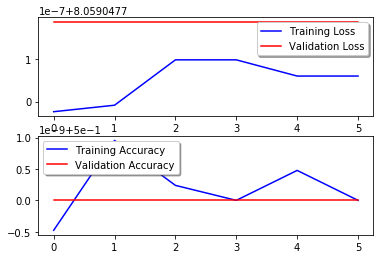

In [17]:
fig, ax = plt.subplots(2,1)
# Loss Plot
ax[0].plot(history.history['loss'], color='b', label="Training Loss")
ax[0].plot(history.history['val_loss'], color='r', label='Validation Loss')

legend = ax[0].legend(loc='best', shadow=True)

# Accuracy Plot
ax[1].plot(history.history['acc'], color='b', label='Training Accuracy')
ax[1].plot(history.history['val_acc'], color='r', label='Validation Accuracy')
legend = ax[1].legend(loc='best', shadow=True)